In [1]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Реализация функции, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики:

Средний чек на всех пользователей - ARPU, 

Средний чек на активных пользователей - ARPAU, 

Конверсия в покупку всех пользователей, 

Конверсия в покупку активных пользователей.

In [2]:
# Загружаю данные

# Информация о принадлежности пользователя к контрольной или экспериментальной группе
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Y2Uxx7pkplu7WQ', sep=';')

# Дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/PM8gm7EU7FVWPg', sep=',')

# Информация о пользователях, которые зашли на платформу в дни проведения эксперимента
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/b1UCahpVw1T_1g')

# Информация об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QGMD0lDBr70lsA', sep=';')

In [3]:
def func(groups, groups_add, active_users, checks):
    """
    Функция:
    Добавляет файл с пользователями, который прислали спустя 2 дня после передачи данных;
    Переименовывает колонки к единому имени;
    Собирает датафрейм из всех файлов с метками оплат и активности, заменяет пустые значения нулями;
    Считает метрики из условия задачи;
    Формирует датафрейм в порядке полей с информацией о кол-ве классификаций пользователей и их метрики
    """
    
    # Добавление дополнительного файла, который прислали спустя 2 дня после передачи данных
    groups_users = pd.concat([groups, groups_add], ignore_index=True)

    # Переименование колонок для мерджа
    active_users.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)

    # Формирую метку о наличии оплаты
    checks['payment'] = 1
    
    # Соединяю всех активных со всеми оплатами
    active = active_users.merge(checks, how='outer', on='id')
    
    # Формирую метку активности
    active['activity'] = 1
    
    total = groups_users.merge(active, how='left', on='id')
    
    # Заменяю NaN на нули
    total = total.fillna(0)
    
    # Средний чек на всех пользователей
    ARPU = total.groupby('grp', as_index=False) \
        .agg({'rev': 'mean'}) \
        .rename(columns={'rev': 'ARPU'}) \
        .round(2)
    
    # Средний чек активных
    ARPAU = total.query('activity == 1') \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'mean'}) \
        .rename(columns={'rev': 'ARPAU'}) \
        .round(2)
    
    # Конверсия в покупку от всех пользователей
    cr = total.groupby('grp', as_index=False) \
        .agg({'payment': 'sum', 'rev': 'count'}) \
        .rename(columns={'rev': 'users'})
    cr['CR'] = round((cr.payment / cr.users), 4)
    
    # Конверсия в покупку активных
    cr_act = total.groupby('grp', as_index=False) \
        .agg({'payment': 'sum', 'activity': 'sum'}) \
        .rename(columns={'activity': 'active_users'})
    cr_act['CR_active'] = round((cr_act.payment / cr_act.active_users), 4)
    
    metrics = pd.concat([cr[['grp', 'users']], 
                         cr_act[['active_users', 'payment']], 
                         ARPU[['ARPU']], 
                         ARPAU[['ARPAU']], 
                         cr[['CR']], 
                         cr_act[['CR_active']]], 
                        axis=1)

    return (metrics)

In [4]:
func.__doc__

'\n    Функция:\n    Добавляет файл с пользователями, который прислали спустя 2 дня после передачи данных;\n    Переименовывает колонки к единому имени;\n    Собирает датафрейм из всех файлов с метками оплат и активности, заменяет пустые значения нулями;\n    Считает метрики из условия задачи;\n    Формирует датафрейм в порядке полей с информацией о кол-ве классификаций пользователей и их метрики\n    '

In [5]:
func(groups, groups_add, active_users, checks)

,grp,users,active_users,payment,ARPU,ARPAU,CR,CR_active
0,A,14693,1567.0,107.0,6.27,58.77,0.0073,0.0683
1,B,59883,6923.0,434.0,8.04,69.51,0.0072,0.0627


# Реализация функции, которая будет строить графики по получаемым метрикам.

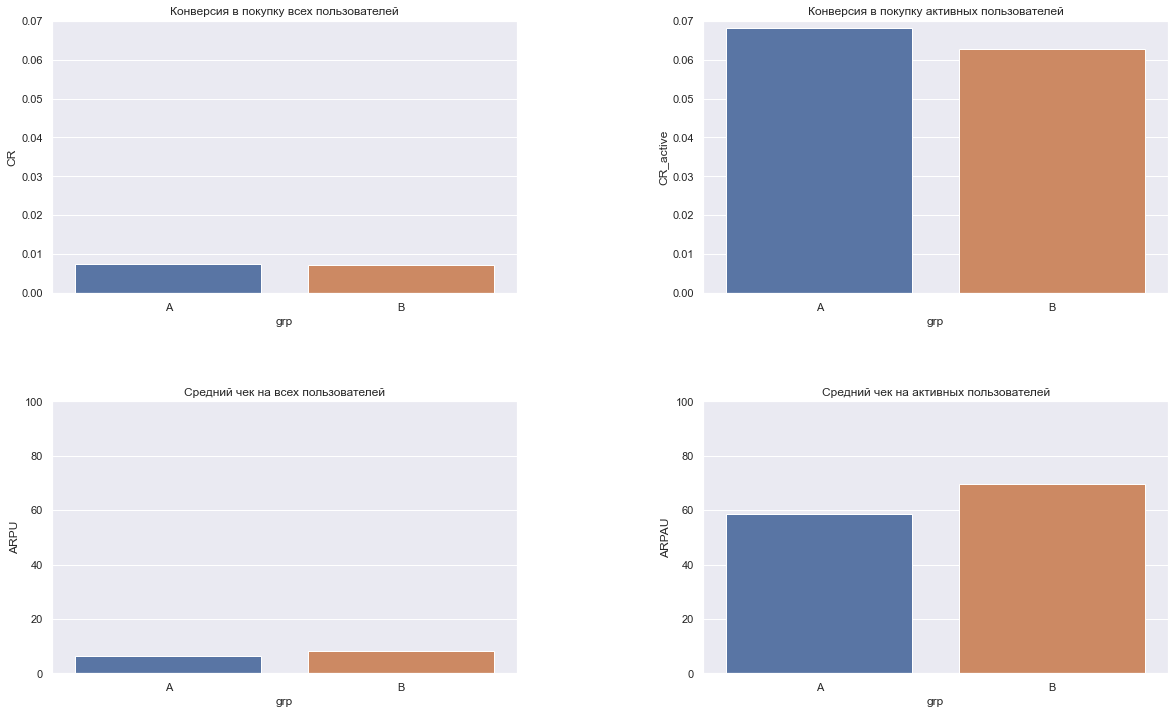

In [6]:
# Постороение графиков: установка размера, расположение сеткой, назначение заголовков, вывод барплотов
def charts(metrics):
    """
    Функция:
    Строит графики по посчитанным выше метрикам: CR, CR_active, ARPU, ARPAU;
    Устанавливает размер графиков и их расположение сеткой;
    Подписывает графики заголовками
    """
    
    sns.set(rc={'figure.figsize': (20, 12)})
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.add_subplot(2, 2, 1)
    plt.title('Конверсия в покупку всех пользователей')
    sns.barplot(data=metrics, x='grp', y='CR').set_ylim(0, 0.07)
    fig.add_subplot(2, 2, 2)
    plt.title('Конверсия в покупку активных пользователей')
    sns.barplot(data=metrics, x='grp', y='CR_active').set_ylim(0, 0.07)
    fig.add_subplot(2, 2, 3)
    plt.title('Средний чек на всех пользователей')
    sns.barplot(data=metrics, x='grp', y='ARPU').set_ylim(0, 100)
    fig.add_subplot(2, 2, 4)
    plt.title('Средний чек на активных пользователей')
    sns.barplot(data=metrics, x='grp', y='ARPAU').set_ylim(0, 100)
    
    
charts(func(groups, groups_add, active_users, checks))

In [7]:
charts.__doc__

'\n    Функция:\n    Строит графики по посчитанным выше метрикам: CR, CR_active, ARPU, ARPAU;\n    Устанавливает размер графиков и их расположение сеткой;\n    Подписывает графики заголовками\n    '